# Inter-Maimi - PROD Retention Score
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

In [18]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [4]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(6925, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  6925 non-null   int64  
 1   year                 6925 non-null   int64  
 2   productGrouping      6925 non-null   object 
 3   totalSpent           6925 non-null   float64
 4   recentDate           6925 non-null   object 
 5   attendancePercent    6925 non-null   float64
 6   renewedBeforeDays    6925 non-null   int64  
 7   source_tenure        6925 non-null   int64  
 8   tenure               6925 non-null   int64  
 9   distToVenue          6680 non-null   float64
 10  recency              6925 non-null   int64  
 11  missed_games_1       6925 non-null   int64  
 12  missed_games_2       6925 non-null   int64  
 13  missed_games_over_2  6925 non-null   int64  
 14  isNextYear_Buyer     6925 non-null   int64  
dtypes: float64(3), int64(10), object(2)
me

### We should specify the features used in our model:

In [6]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (3596, 15)
Unseen Data For Predictions: (634, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [7]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6397,0.7007,0.6769,0.6229,0.6480,0.2804,0.2821,0.7470


In [9]:
lightgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6405,0.6971,0.7200,0.6136,0.6626,0.2832,0.2873
1,0.6601,0.7329,0.7000,0.6402,0.6688,0.3212,0.3226
2,0.6242,0.6782,0.6800,0.6036,0.6395,0.2499,0.2518
3,0.6667,0.7513,0.6333,0.6690,0.6507,0.3324,0.3328
4,0.6569,0.7124,0.6400,0.6531,0.6465,0.3132,0.3133
5,0.6242,0.6920,0.6867,0.6023,0.6417,0.2501,0.2525
6,0.6033,0.6934,0.6467,0.5879,0.6159,0.2076,0.2086
7,0.6426,0.7066,0.7067,0.6199,0.6604,0.2867,0.2894
8,0.6361,0.6518,0.6510,0.6218,0.6361,0.2725,0.2728
9,0.6426,0.6911,0.7047,0.6176,0.6583,0.2871,0.2899


### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2695, 15)

In [11]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)

In [12]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")

lightgbm:
 0    2454
1     241
Name: Label, dtype: int64


In [13]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    1701
(0.25, 0.5]        753
(0.5, 0.75]        211
(0.75, 1.0]         30
Name: Score_1, dtype: int64


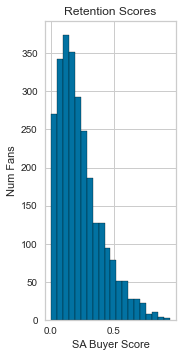

In [14]:
model_predictions = [lightgbm_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

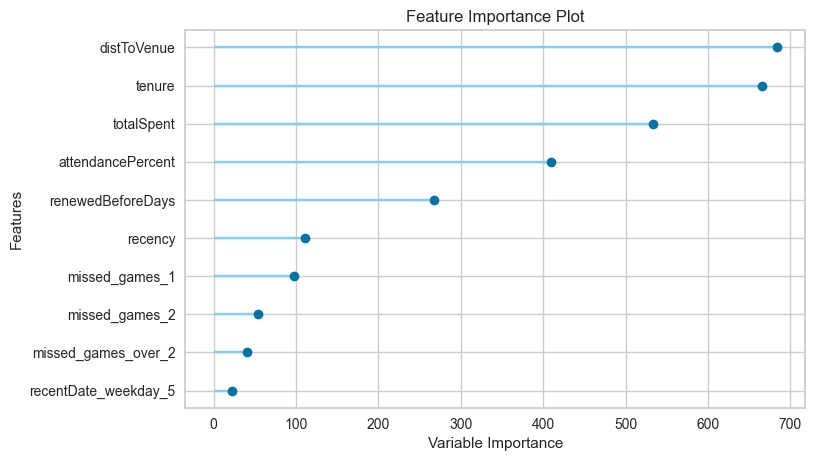

In [15]:
plot_model(lightgbm_model, plot='feature')

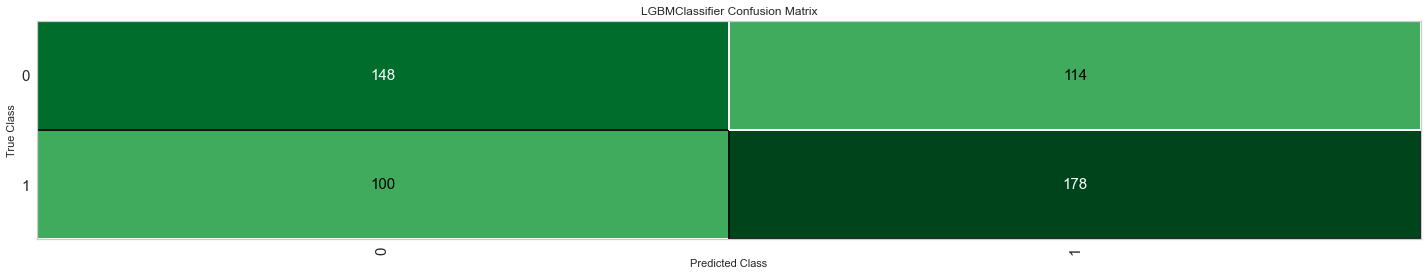

In [16]:
plot_model(lightgbm_model, plot='confusion_matrix')

In [17]:
lightgbm_predictions

,dimCustomerMasterId,year,productGrouping,totalSpent,recentDate,attendancePercent,renewedBeforeDays,source_tenure,tenure,distToVenue,recency,missed_games_1,missed_games_2,missed_games_over_2,isNextYear_Buyer,Label,Score_0,Score_1
0,46,2022,Flex Plan,312.00,2022-07-13,0.88,10,730,150,38.20,0,0,0,0,0,0,0.9919,0.0081
3,107,2022,Full Season,12257.00,2022-07-16,0.61,162,730,949,48.37,0,0,0,1,0,0,0.5664,0.4336
6,121,2022,Full Season,875.50,2022-07-16,0.55,159,730,950,57.52,0,1,2,0,0,0,0.8641,0.1359
8,157,2022,Full Season,850.00,2022-07-13,0.73,33,1095,1095,17.84,1,3,0,0,0,0,0.5968,0.4032
10,172,2022,Full Season,595.00,2022-07-16,0.91,101,730,1073,52.21,0,1,0,0,0,0,0.8573,0.1427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6920,152847,2022,Full Season,4488.00,2022-07-13,0.64,87,365,312,63.66,1,2,1,0,0,0,0.5253,0.4747
6921,152860,2022,Full Season,159750.08,2022-07-16,0.25,15,365,240,0.00,0,3,0,0,0,0,0.6368,0.3632
6922,152862,2022,Full Season,352.72,2022-06-25,0.27,73,365,241,46.24,2,0,2,1,0,0,0.8323,0.1677
6923,153123,2022,Full Season,1156.00,2022-05-28,0.50,73,365,298,17.51,3,0,1,1,0,0,0.7350,0.2650


In [19]:
current_date = datetime.today().strftime('%Y-%m-%d')
lightgbm_predictions.to_csv(f"Results/InterMiami_Retention_Scores_{current_date}.csv", index=False)